# Estimation de l'ATE/CATE sur des données synthétiques

In [1]:
import numpy as np
from scipy.stats import bernoulli
import scipy as sp
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams['figure.figsize'] = 10, 8

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install causalml

     |████████████████████████████████| 245kB 5.6MB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 327kB 48.8MB/s 
     |████████████████████████████████| 1.8MB 48.1MB/s 
     |████████████████████████████████| 634kB 38.5MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493677 sha256=9a700ae81ac811363b16d619285db2d91b9e96599197cfa1c7fb678458779bac
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465027 sha256=250e78fc24e032a63656e667ee0220609c1877707e3fe046feb9e701da04b747
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement

In [3]:
import causalml

## Génération de données

In [4]:
def treatment_assign(Nobs, X, p):
    '''
    Input: 
    
    p : score de propension.
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    
    Output:
    
    W : Vecteur de taille Nobs contenant des 0 ou 1 pour désigner l'affectation du traitement.
    '''
    sigmoid = lambda x: 1/(1+np.exp(-x))
    
    omega = np.random.uniform(0, 1, (Nobs, d))
    psi = np.random.uniform(0, 1, (Nobs, 1))

    if p == None:
      p = np.zeros(Nobs)
      for i in range(Nobs):
        p[i] = sigmoid(omega[i] @ X[i])
      W = bernoulli.rvs(p, size = Nobs) 
    else:
      W = bernoulli.rvs(p, size = Nobs) 
    
    return W

In [5]:
def causal_generation(Nobs, dim, beta, bias, f, g, p):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, Y, W) : Triplet contenant la matrice X des features, Y le vecteur des résultats potentiels et 
                W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    Y = np.zeros(Nobs)

    W = treatment_assign(Nobs, X, p)

    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

## S-learners

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.features = np.hstack((self.X, self.W[:,np.newaxis]))
        self.clf = self.estimator.fit(self.features, self.Y)

    def predict_CATE(self, x):
        # Complete the method      
        self.Y_0_hat = self.clf.predict(np.c_[x, np.zeros(len(x))])
        self.Y_1_hat = self.clf.predict(np.c_[x, np.ones(len(x))])
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## T-learners

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X = X
        self.W = W
        self.Y = Y
        self.mu_0 = self.estimator0.fit(X[self.W==0,:], self.Y[self.W==0])
        self.mu_1 = self.estimator1.fit(X[self.W==1,:], self.Y[self.W==1])

    def predict_CATE(self, x):
        # Complete the method         
        self.Y_0_hat = self.mu_0.predict(x)
        self.Y_1_hat = self.mu_1.predict(x)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## X-Learners ( a faire)

## Phase de test ( cas simple)

### Initialisation des paramètres (cas simple)

In [8]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 1000
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.7
beta = np.random.uniform(1, 30, (1, d))
beta = np.vstack((beta,beta))               # beta0 = beta1           
bias = np.array([10,0])                   # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:x

In [9]:
print(beta, bias)

[[14.71020111  1.51326296]
 [14.71020111  1.51326296]] [10  0]


### Générations des données (cas simple)

In [10]:
# Génération des données
X, W, Y = causal_generation(N, d, beta, bias, f, g, p)

### Prédictions des métalearners "Team Filrouge"

#### Slearners

In [11]:
slearner = SLearner(base_estimator=LinearRegression())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -9.977816265515543.


#### Tlearners

In [12]:
tlearner = TLearner(base_estimator0=LinearRegression(),base_estimator1=LinearRegression())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE(X)
print("- Les dimensions du CATE = {}.".format(cate_hat_T.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -9.97791302526238.


### Prédictions des métalearners "Causal ML"

#### Slearners

In [13]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): -9.98 (-10.11, -9.84)


#### Tlearners

In [14]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

[17:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
L'estimation de la valeur de l'ATE (XGBoost): -9.91 (-10.02, -9.79)


### Paradis

#### Calcul de l'ATE

In [15]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
  p=beta.shape[1]
  if p==1:
    ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
  if p==2:
    ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
    )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
  if p>2:
    raise Warning('dimension above 2')
  return  ate

In [16]:
def monte_carlo(Nobs, dim, beta, bias, f, g):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim), note dim doit être < 10
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    ATE : ATE calculé par la méthode de Monte Carlo
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    ATE = np.mean(g(X.dot(beta[1])+ bias[1]) - f(X.dot(beta[0])+ bias[0])) 
            
    return ATE

In [17]:
print('ATE: {}'.format(ATE_paradis(beta, bias, f, g)))
print('ATE par monte carlo: {}'.format(monte_carlo(10**6, d, beta, bias, f, g)))

ATE: (-9.999999994531066, 1.4324331266465507e-08)
ATE par monte carlo: -10.0


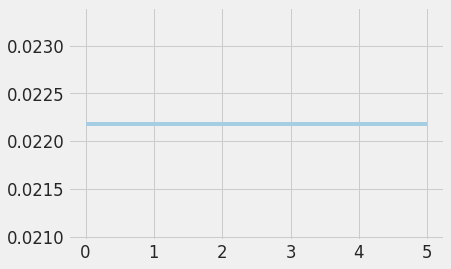

In [18]:
res = []
#1- varier Nobs pour ate_hat_S et le comparer avec mc_est (meth. monte carlo) avec 10**8
#2 - ajouter une courbe avec l'estimation avec causalml avec la borne inf et max et ate_hat_S
for i in range(2,8):
    mc_est = monte_carlo(10**i, d, beta, bias, f, g)
    res.append([abs(mc_est - ate_hat_S)])
plt.figure()
plt.plot(res)

#### Calcul des IC

In [19]:
def causal_generation_bootstrap(beta, bias, B, Nobs, dim, f, g, p):
    '''
    Create list of bootstrap elements
    Input :
    B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes, 1000 par défaut
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features), 2 par défaut
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions, identité par défaut
    
    Output:
    [(X, W, Y)] : liste de B Triplets contenant la matrice X des features, W 
    le vecteur de l'affectation du traitement et Y le vecteur des résultats 
    potentiels. 
                
    '''
    Bootstraps=[]

    for b in range(B):
        Bootstraps.append(causal_generation(Nobs, dim, beta, bias, f, g, p))
      
    return Bootstraps

In [20]:
def IC(Bootstraps, base_metalerner=SLearner(), alpha=0.05):
    
    '''
    Calculate l'intervalle de confiance d'un métalearner
    
    Input :
    Bootstraps : Liste d'échantillons Boostraps comprenant B triplets (X,Y,W)
    base_metalerner : metalearner à évaluer
    
    Output:
    IC : (IC inf , IC sup) du métalearner 
    '''
    
    #Calcul de l'ATE les B estimateurs du Bootstrap
    ATEs = np.zeros((len(Bootstraps)))
    base_metalearner = SLearner()
    
    for i in range(len(Bootstraps)):
        base_metalearner.fit(Bootstraps[i][0], Bootstraps[i][1], Bootstraps[i][2])
        base_metalearner.predict_CATE(Bootstraps[i][0])
        ATEs[i] = base_metalearner.predict_ATE()
    
    #Calcul des intervalles de confiance
    Mu_ATEs = ATEs.mean()
    std_ATEs = ATEs.std()
    ATEs_tilt = (ATEs-Mu_ATEs)/std_ATEs
    ATEs_tilt.sort()
    ATEs.sort()
    
    B = len(Bootstraps)
    IC_inf, IC_sup = ATEs[int(B*(alpha/(2)))], ATEs[int(B*(1-alpha/(2)))]
    
    return Mu_ATEs, IC_inf, IC_sup

In [21]:
 # Intervalle de confiance
B = 999
Bootstraps = causal_generation_bootstrap(beta, bias, B, N, d, f, g, p)
_, IC_inf, IC_sup = IC(Bootstraps, base_metalerner = SLearner(), alpha=0.05)
print("- Intervalle de confiance pour l'ATE : [{}, {}].".format(IC_inf, IC_sup))

- Intervalle de confiance pour l'ATE : [-10.13621427566111, -9.865085766920602].


In [22]:
def visualization(beta, bias, B, N, d, f, g, p, base_metalerner=SLearner()):
    ates = []
    ates_inf = []
    ates_sup = []
    B = 999
    
    for i in range(100,1000,100):
        Bootstraps = causal_generation_bootstrap(beta, bias, B, N, d, f, g, p)
        mu, inf, sup = IC(Bootstraps, base_metalerner, alpha=0.05)
        ates.append(mu)
        ates_inf.append(inf)
        ates_sup.append(sup)

    plt.figure(figsize=(10,8))
    x=np.arange(100,1000,100)
    plt.plot(x, ates, color='k',label='ATE')
    plt.fill_between(x, ates_inf,ates_sup)
    plt.ylim(min(ates_inf)-1,min(ates_inf)+1)
    plt.xlabel("N observations")
    plt.ylabel("ATE")
    plt.title("Evaluation de l'ATE en fonction du nombre d'observations")
    plt.legend(loc=1,numpoints=1)

    plt.show();

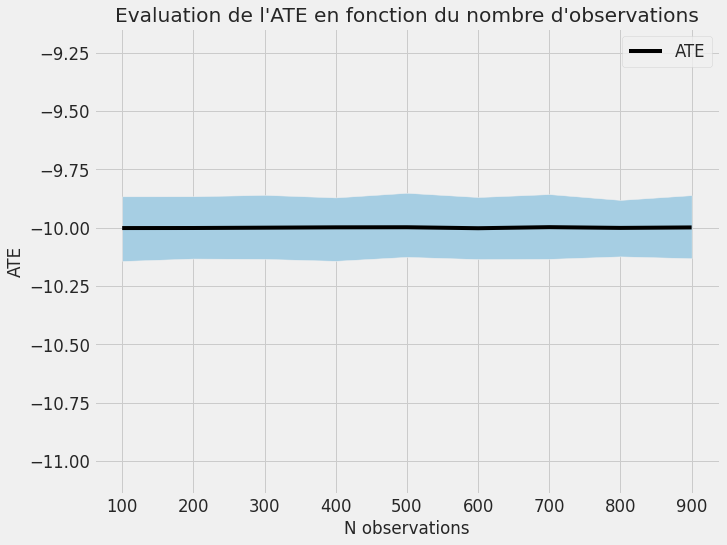

In [23]:
visualization(beta, bias, B, N, d, f, g, p, base_metalerner = SLearner())

# Graphique de comparaison S Learner

In [39]:
def graphic_comparison(nb_obs, d, p, beta, bias, f, g, B, base_learner_homemade, base_learner_causalml):

  '''
  Create a graphic to compare our bases learners vs base learners from causalml 

  Input :
    
  B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
  nb_obs : Nombre de lignes da la matrice X, les listes sont acceptables i.e. nombre de personnes, 1000 par défaut
  dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features), 2 par défaut
  beta : Vecteur de dimension (2, dim).
  bias : Vecteur de dimension (1, 2).
  W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
  f et g sont des fonctions, identité par défaut
    
  Output:
  Graphique comparant nos base_learner avec ceux du causal_ml
  '''

  ate_causal_ml = []
  lb_causal_ml = []
  ub_causal_ml = []

  ates = []
  ates_inf = []
  ates_sup = []

  for n in nb_obs :

    # Génération des données
    Bootstraps = causal_generation_bootstrap(beta, bias, B, n, d, f, g, p)
    mu, inf, sup = IC(Bootstraps, base_metalerner=base_learner_homemade, alpha=0.05)
    ates.append(mu)
    ates_inf.append(inf)
    ates_sup.append(sup)

    # S learner causal ML
    X, W, Y = causal_generation(n, d, beta, bias, f, g, p)
    lr = base_learner_causalml
    te, lb, ub = lr.estimate_ate(X, W, Y)
    ate_causal_ml.append(te[0])
    lb_causal_ml.append(lb[0])
    ub_causal_ml.append(ub[0])


  plt.figure(figsize=(12,7))
  plt.plot(nb_obs,ates, color='blue',label = 'ATE_homemade')
  plt.fill_between(nb_obs, ates_inf,ates_sup,alpha = 0.5, color='blue', label = 'IC_ATE_homemade')
  plt.plot(nb_obs, ate_causal_ml,color='orange',label='ATE_causal_ml')
  plt.fill_between(nb_obs, lb_causal_ml, ub_causal_ml,alpha = 0.5, color='orange',label='IC_ATE_causalml')
  plt.xlabel("Nombre d'observations")
  plt.ylabel("Valeurs de l'ATE")
  plt.title("Evaluations de l'ATE en fonction du nombre d'observations")
  plt.legend()
  plt.show()
  

In [40]:
nb_obs = [i for i in range(100,2000,100)]
d = 2
p = 0.7
B = 999             
f = lambda x:x
g = lambda x:x
base_learner_homemade = SLearner()
base_learner_causalml = LRSRegressor()

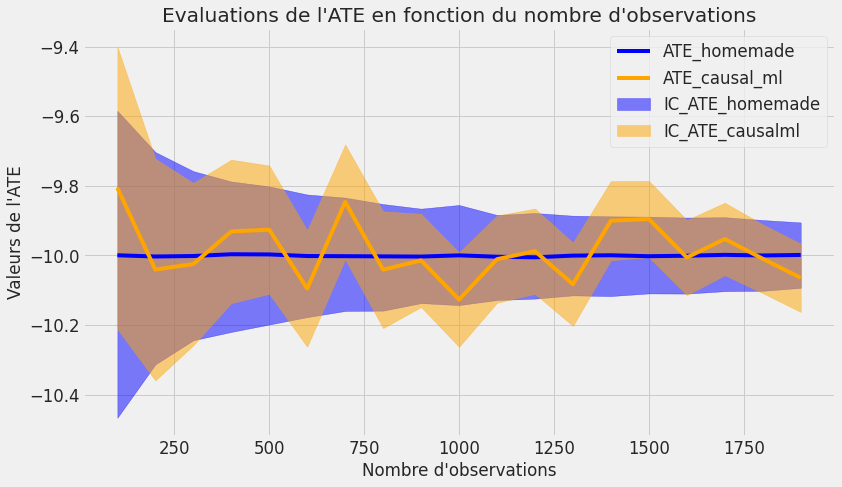

In [41]:
graphic_comparison(nb_obs, 2, p, beta, bias, f, g, B, base_learner_homemade=SLearner(), base_learner_causalml=LRSRegressor())